In [0]:
%tensorflow_version 2.x

In [0]:
import zipfile
zipfile1 = zipfile.ZipFile("drive/My Drive/test/fox (2).zip")
zipfile2 = zipfile.ZipFile("drive/My Drive/test/racoon.zip")
# 不要解在自己的google drive 下
zipfile1.extractall("dataset")
zipfile2.extractall("dataset")

In [3]:
import glob
import pandas as pd
foxfn = glob.glob("dataset/fox/*")
foxans = [0] * len(foxfn)
racoonfn = glob.glob("dataset/racoon/*")
racoonans = [1] * len(racoonfn)
df = pd.DataFrame({
    "path" : foxfn + racoonfn,
    "target" : foxans + racoonans
})
df

,path,target
0,dataset/fox/675.jpg,0
1,dataset/fox/720.jpg,0
2,dataset/fox/121.jpg,0
3,dataset/fox/401.jpg,0
4,dataset/fox/141.jpg,0
...,...,...
794,dataset/racoon/790.jpg,1
795,dataset/racoon/102.jpg,1
796,dataset/racoon/402.jpg,1
797,dataset/racoon/562.jpeg,1


In [4]:
from tensorflow.keras.preprocessing.image import load_img
p = 'dataset/fox/0.jpg'
img = load_img(p)
print(img.size)

(680, 480)


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
# 不管是 model / layer => input, output 都是 tensor
# 使用方式 : Tensor = function( Tensor )
for l in cnn.layers:
  # 一定要設, complie 前設定好
  l.trainable = False
x = BatchNormalization()(cnn.output)
# BatchNormalization 一定要 Flatten 之前
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.15)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs = cnn.input, outputs = out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 傳進模型前
# 好習慣: 先全部轉成 numpy array 
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [9]:
# caffe: -120 ~ 120, tf: -1 ~ 1, toch: 平均為0, 標準差為1
# 記得依當初別人用的處理方式處理: caffe, tensorflow, pytoch
from tensorflow.keras.applications.vgg16 import preprocess_input
# return value: (原圖, 預處理過的圖, 答案)
def dataflow(x, y, BATCH=20):
  idx = np.random.randint(0, x.shape[0], size=BATCH)
  img_raw, img_process = [], []
  for p in x[idx]:
    img = load_img(p, target_size=(224, 224))
    img_np = np.array(img)
    img_raw.append(img_np)
    img_pre = preprocess_input(img_np)
    img_process.append(img_pre)
  return (np.array(img_raw),
          np.array(img_process),
          np.array(y[idx]))
data = dataflow(x_train, y_train)
print(data[0].shape, data[1].shape, data[2].shape)

(20, 224, 224, 3) (20, 224, 224, 3) (20,)


In [10]:
# train_on batch v.s. fit_generater
for i in range(30):
  print("-" * 15, i, "-" * 15)
  raw, img, ans = dataflow(x_train, y_train)
  train_result = model.train_on_batch(img, ans)
  print("Train:", train_result)
  raw, img, ans = dataflow(x_test, y_test)
  test_result = model.test_on_batch(img, ans)
  print("Validate:", test_result)
# 數值大幅震盪 => BatchNormalization
# 數值穩定降不下來 => 調整模型

--------------- 0 ---------------
Train: [0.8047744035720825, 0.550000011920929]
Validate: [34.096683502197266, 0.44999998807907104]
--------------- 1 ---------------
Train: [8.123025894165039, 0.20000000298023224]
Validate: [13.394935607910156, 0.699999988079071]
--------------- 2 ---------------
Train: [2.572253704071045, 0.6000000238418579]
Validate: [8.95505428314209, 0.800000011920929]
--------------- 3 ---------------
Train: [0.6091630458831787, 0.6499999761581421]
Validate: [1.396482229232788, 0.699999988079071]
--------------- 4 ---------------
Train: [0.45031604170799255, 0.800000011920929]
Validate: [2.879833698272705, 0.8500000238418579]
--------------- 5 ---------------
Train: [0.3790964186191559, 0.75]
Validate: [1.2029815912246704, 0.8500000238418579]
--------------- 6 ---------------
Train: [0.2878257632255554, 0.8500000238418579]
Validate: [3.7851815223693848, 0.800000011920929]
--------------- 7 ---------------
Train: [0.11121400445699692, 0.8999999761581421]
Validate:

In [11]:
model.predict(img)

array([[5.02837194e-09, 1.00000000e+00],
       [1.00000000e+00, 2.71234316e-25],
       [1.00000000e+00, 3.59088332e-08],
       [1.00000000e+00, 2.42638468e-22],
       [1.00000000e+00, 2.42638468e-22],
       [1.37950946e-22, 1.00000000e+00],
       [1.00000000e+00, 3.95620257e-14],
       [1.09652660e-08, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 3.85929535e-34],
       [8.00686030e-05, 9.99919891e-01],
       [1.04187249e-11, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.66788084e-06, 9.99998331e-01],
       [1.10198849e-19, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99896646e-01, 1.03396706e-04],
       [1.10198849e-19, 1.00000000e+00],
       [7.65444823e-28, 1.00000000e+00],
       [1.00000000e+00, 1.05468767e-09]], dtype=float32)

In [12]:
raw, img, ans = dataflow(x_test, y_test, 500)
model.evaluate(img, ans)

16/16 [==============================] - 2s 112ms/step - loss: 1.1186 - accuracy: 0.9380


[1.118613362312317, 0.9380000233650208]

In [13]:
# Model(非 Sequential): 沒有 predict_classes
#  .argmax(axis=1) 找出列(兩個中)最大值的索引
pre = model.predict(img).argmax(axis=1)
pre

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,

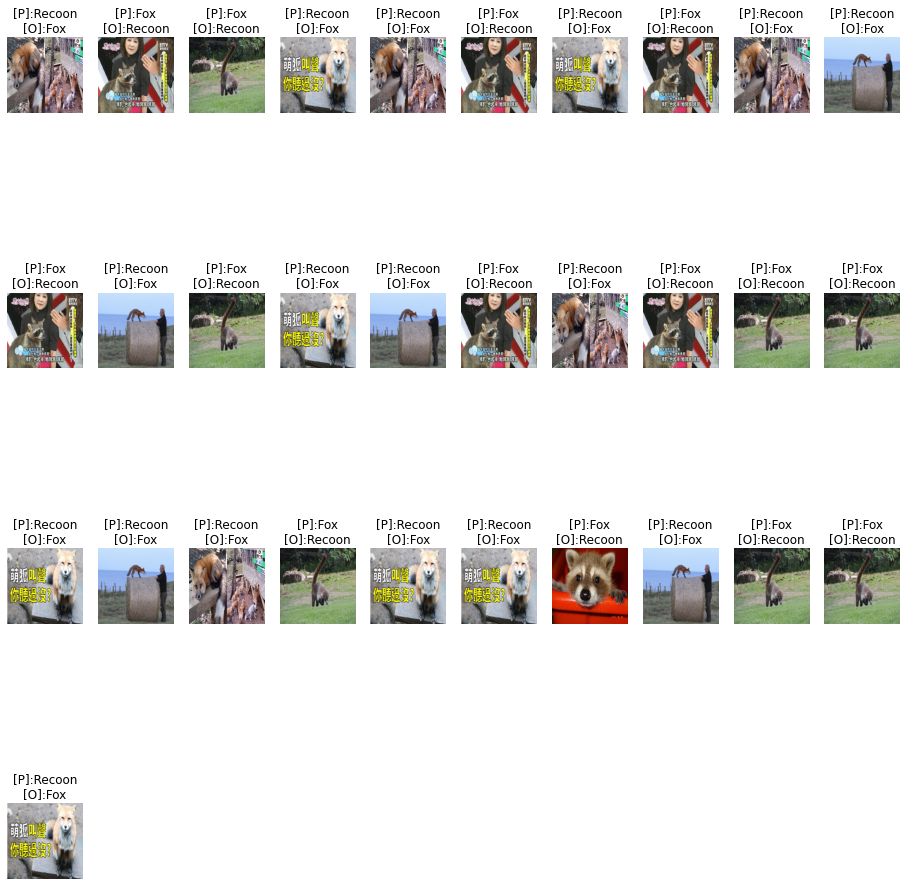

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# [:200]: 太多錯, 我只取前兩百個
names = ["Fox", "Recoon"]
idx = np.nonzero(pre != ans)[0]
false_pre_img = raw[idx]
false_pre_label = ans[idx]
false_pre_predict = pre[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(16, 18))
for i, img in enumerate(false_pre_img):
    plt.subplot(height, width, i+1)
    t = "[P]:{}\n[O]:{}".format(names[false_pre_predict[i]],
                                names[false_pre_label[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)